## Import dependencies

In [29]:
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Plotting
%matplotlib inline
import matplotlib.pyplot as plt

# NLP libraries
import nltk
from wordcloud import WordCloud, ImageColorGenerator
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Data import/processing
import sqlalchemy as db
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, Integer, Table, Column, MetaData
import pandas as pd
import numpy as np

# For color mapping in word cloud
from PIL import Image,ImageOps

## Download packages

In [2]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\curt0\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\curt0\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\curt0\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\curt0\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

## Access database and reflect metadata

In [3]:
# Create SQLite db
restaurants_db = "restaurants.sqlite"
connector = (f"sqlite:///{restaurants_db}")

# Create engine
engine = create_engine(connector)

# Create metadata access to the object
meta_data = db.MetaData(bind=engine)
db.MetaData.reflect(meta_data)

## Import comments into a dataframe

In [4]:
# Select data into dataframe
sql_join = r"select Reviews.business_id, Reviews.text from Reviews inner join Restaurants on Reviews.business_id = Restaurants.business_id where Restaurants.is_mexican_restaurant = 1"
reviews_df = pd.read_sql(sql_join, engine)

reviews_df.head()

,business_id,text
0,WEouNHHxfqGa8gYAnyiyBA,Always delicious!! And great friendly staff!
1,WEouNHHxfqGa8gYAnyiyBA,"Closed as of 10\/7, moving to Eastlake 11\/1."
2,to2cGMKdaw7ZHbXMzpfhlA,"They also have a light menu, consisting of hea..."
3,kiU9C58n7dgygdrpjOQXMQ,Tue-Thurs there's a different taco for 99¢. We...
4,kiU9C58n7dgygdrpjOQXMQ,Carnitas are awesome


In [5]:
with pd.option_context('display.max_rows', None,):
    print(reviews_df.nunique())


business_id      938
text           11427
dtype: int64


In [6]:
reviews_df['text'] = reviews_df['text'].astype(str).str.lower()
reviews_df.head(3)

,business_id,text
0,WEouNHHxfqGa8gYAnyiyBA,always delicious!! and great friendly staff!
1,WEouNHHxfqGa8gYAnyiyBA,"closed as of 10\/7, moving to eastlake 11\/1."
2,to2cGMKdaw7ZHbXMzpfhlA,"they also have a light menu, consisting of hea..."


## Data cleaning

In [7]:
# Apply tokenizer
regexp = RegexpTokenizer('\w+')

reviews_df['text_token']=reviews_df['text'].apply(regexp.tokenize)
reviews_df.head(3)

,business_id,text,text_token
0,WEouNHHxfqGa8gYAnyiyBA,always delicious!! and great friendly staff!,"[always, delicious, and, great, friendly, staff]"
1,WEouNHHxfqGa8gYAnyiyBA,"closed as of 10\/7, moving to eastlake 11\/1.","[closed, as, of, 10, 7, moving, to, eastlake, ..."
2,to2cGMKdaw7ZHbXMzpfhlA,"they also have a light menu, consisting of hea...","[they, also, have, a, light, menu, consisting,..."


In [8]:
# Remove stop words
# Make a list of english stopwords
stopwords = nltk.corpus.stopwords.words("english")

# Extend the list with your own custom stopwords
my_stopwords = ['https']
stopwords.extend(my_stopwords)

# Remove stopwords
reviews_df['text_token'] = reviews_df['text_token'].apply(lambda x: [item for item in x if item not in stopwords])
reviews_df.head(3)

,business_id,text,text_token
0,WEouNHHxfqGa8gYAnyiyBA,always delicious!! and great friendly staff!,"[always, delicious, great, friendly, staff]"
1,WEouNHHxfqGa8gYAnyiyBA,"closed as of 10\/7, moving to eastlake 11\/1.","[closed, 10, 7, moving, eastlake, 11, 1]"
2,to2cGMKdaw7ZHbXMzpfhlA,"they also have a light menu, consisting of hea...","[also, light, menu, consisting, healthier, opt..."


In [9]:
# Remove infrequent words
reviews_df['text_string'] = reviews_df['text_token'].apply(lambda x: ' '.join([item for item in x if len(item)>2]))

reviews_df[['text', 'text_token', 'text_string']].head()

,text,text_token,text_string
0,always delicious!! and great friendly staff!,"[always, delicious, great, friendly, staff]",always delicious great friendly staff
1,"closed as of 10\/7, moving to eastlake 11\/1.","[closed, 10, 7, moving, eastlake, 11, 1]",closed moving eastlake
2,"they also have a light menu, consisting of hea...","[also, light, menu, consisting, healthier, opt...",also light menu consisting healthier options c...
3,tue-thurs there's a different taco for 99¢. we...,"[tue, thurs, different, taco, 99, weds, al, pa...",tue thurs different taco weds pastor
4,carnitas are awesome,"[carnitas, awesome]",carnitas awesome


In [10]:
# Create a list of all words
all_words = ' '.join([word for word in reviews_df['text_string']])

# Tokenize all the words
tokenized_words = nltk.tokenize.word_tokenize(all_words)

In [11]:
# Create a frequency distribution
from nltk.probability import FreqDist

fdist = FreqDist(tokenized_words)
fdist


FreqDist({'food': 1978, 'great': 1718, 'good': 1467, 'tacos': 1081, 'place': 1036, 'service': 968, 'best': 707, 'salsa': 617, 'mexican': 576, 'love': 544, ...})

In [12]:
# Drop infrequently used words
reviews_df['text_string_fdist'] = reviews_df['text_token'].apply(lambda x: ' '.join([item for item in x if fdist[item] >= 1 ]))
reviews_df[['text', 'text_token', 'text_string', 'text_string_fdist']].head()

,text,text_token,text_string,text_string_fdist
0,always delicious!! and great friendly staff!,"[always, delicious, great, friendly, staff]",always delicious great friendly staff,always delicious great friendly staff
1,"closed as of 10\/7, moving to eastlake 11\/1.","[closed, 10, 7, moving, eastlake, 11, 1]",closed moving eastlake,closed moving eastlake
2,"they also have a light menu, consisting of hea...","[also, light, menu, consisting, healthier, opt...",also light menu consisting healthier options c...,also light menu consisting healthier options c...
3,tue-thurs there's a different taco for 99¢. we...,"[tue, thurs, different, taco, 99, weds, al, pa...",tue thurs different taco weds pastor,tue thurs different taco weds pastor
4,carnitas are awesome,"[carnitas, awesome]",carnitas awesome,carnitas awesome


In [13]:
# Apply lemmatization
wordnet_lem = WordNetLemmatizer()

reviews_df['text_string_lem'] = reviews_df['text_string_fdist'].apply(wordnet_lem.lemmatize)

In [14]:
# check if the columns are equal
reviews_df['is_equal'] = (reviews_df['text_string_fdist']==reviews_df['text_string_lem'])

In [15]:
# show level count
reviews_df.is_equal.value_counts()

True     11657
False       60
Name: is_equal, dtype: int64

In [16]:
# Create a list of the lemmatized words
all_words_lem = ' '.join([word for word in reviews_df['text_string_lem']])

## Create word cloud

In [36]:
image = np.array(Image.open("colormap.png"))

image_mask = image.copy()
image[image_mask.sum(axis=2) == 0] = 255

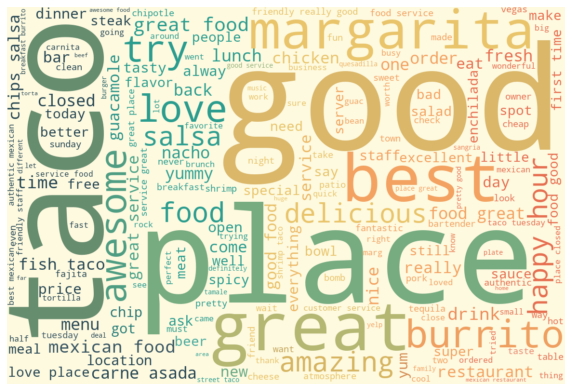

In [40]:
# Word cloud of all lemmatized words, style one
wc = WordCloud(background_color='#FEFAE0', 
               mask=image_mask, 
               mode='RGBA')

image_colors = ImageColorGenerator(image)

wc.generate(all_words_lem)
wc.recolor(color_func=image_colors)

plt.figure(figsize=(10, 10))
plt.imshow(wc, interpolation="bilinear")
plt.axis('off');

wc.to_file("color_masked_wordcloud.png")